# WCRC MIRS instruments 

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.cli import *

In [ ]:
from spanda.data.transforms.wcrc import (get_spectra_files, to_spectra, 
                                         snv, AnalytesTfm)

from pathlib import Path
from fastai.vision.all import *
from fastai.callback.hook import *
from fastai.data.all import *
from fastcore.parallel import parallel
from tqdm import tqdm

from mirzai.data.transform import TakeDerivative, SNV, DropSpectralRegions
from mirzai.vis.core import plot_spectra
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import kennard_stone as ks
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from scipy.stats import skew

import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## PLSR

In [ ]:
#org = 'Woodwell_vertex'
org = 'IAEA_jun2022'
#org = 'ETH_alpha_1'
analyte = 'potassium_cmolkg'

path = Path('../../_data/wcrc-ct-bundled') / org / analyte; path

Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg')

In [ ]:
(path / 'train').ls()

(#47) [Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_23'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_24'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_12'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_15'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_41'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_46'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_48'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_25'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_22'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_40')...]

In [ ]:
(path / 'test').ls()

(#12) [Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_14'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_13'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_49'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_47'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_55'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_06'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_01'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_26'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_04'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/test/RT_35')...]

In [ ]:
wns = pd.read_csv((path / 'train').ls()[0] / 'spectrum.csv')['wavenumber'].values; wns

array([4000, 3998, 3996, ...,  606,  604,  602])

In [ ]:
Xs = []
for ds in ['train', 'test']:
    Xs.append(np.c_[[pd.read_csv(p / 'spectrum.csv')['absorbance'].values 
                     for p in (path / ds).ls()]])
X_train, X_test = Xs

(array([[42.,  5.,  0., ...,  0.,  0.,  0.],
        [42.,  5.,  0., ...,  0.,  0.,  0.],
        [42.,  5.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., 23.,  4.,  0.],
        [ 0.,  0.,  0., ..., 26.,  3.,  0.],
        [ 0.,  0.,  0., ..., 23.,  4.,  0.]]),
 array([0.84133 , 1.040604, 1.239878, 1.439152, 1.638426, 1.8377  ,
        2.036974, 2.236248, 2.435522, 2.634796, 2.83407 ]),
 <a list of 1700 BarContainer objects>)

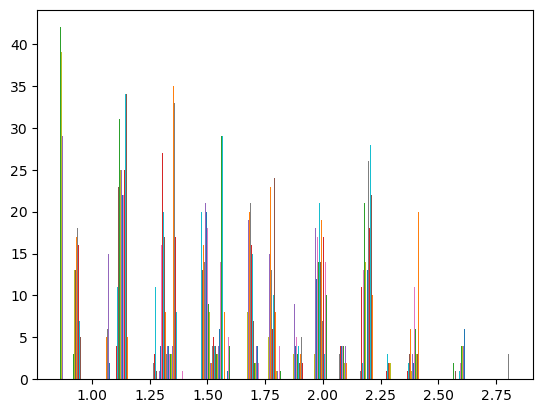

In [ ]:
plt.hist(X_train)

(array([[ 7., 24., 11., ...,  0.,  0.,  0.],
        [ 7., 24., 11., ...,  0.,  0.,  0.],
        [ 7., 24., 11., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  2.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.]]),
 array([0.72742 , 0.858066, 0.988712, 1.119358, 1.250004, 1.38065 ,
        1.511296, 1.641942, 1.772588, 1.903234, 2.03388 ]),
 <a list of 1700 BarContainer objects>)

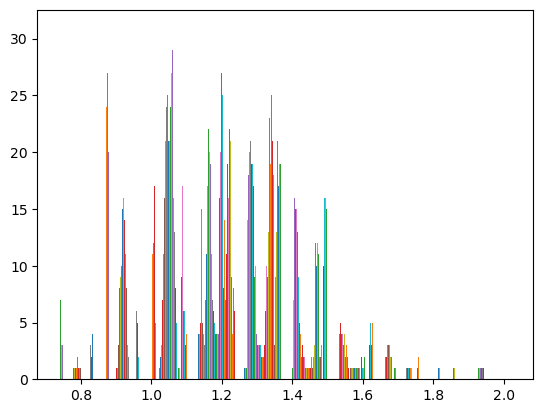

In [ ]:
plt.hist(X_train)

In [ ]:
ys = []
for ds in ['train', 'test']:
    ys.append(np.c_[[pd.read_csv(p / 'target.csv')['value'].values 
                     for p in (path / ds).ls()]])
y_train, y_test = ys

In [ ]:
print(f'# of training sample: {y_train.shape[0]}, # of test samples: {y_test.shape[0]}')

# of training sample: 47, # of test samples: 12


In [ ]:
# y transforms if required
y_train, y_test = [np.log10(y) for y in [y_train, y_test]]

In [ ]:
wns

array([4000, 3998, 3996, ...,  606,  604,  602])

In [ ]:
X_train.shape

(47, 1700)

In [ ]:
wns

array([4000, 3998, 3996, ...,  606,  604,  602])

In [ ]:
def plot_spectra(X, X_names, sample=20, alpha=0.8, color='#333', figsize=(20, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    idx = np.random.randint(X.shape[0], size=sample)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.locator_params(axis="x", nbins=20)
    plt.xlabel('Wavenumber')
    plt.ylabel('Absorbance')
    _ = ax.plot(X_names, X[idx, :].T, lw=1, c=color, alpha=alpha)

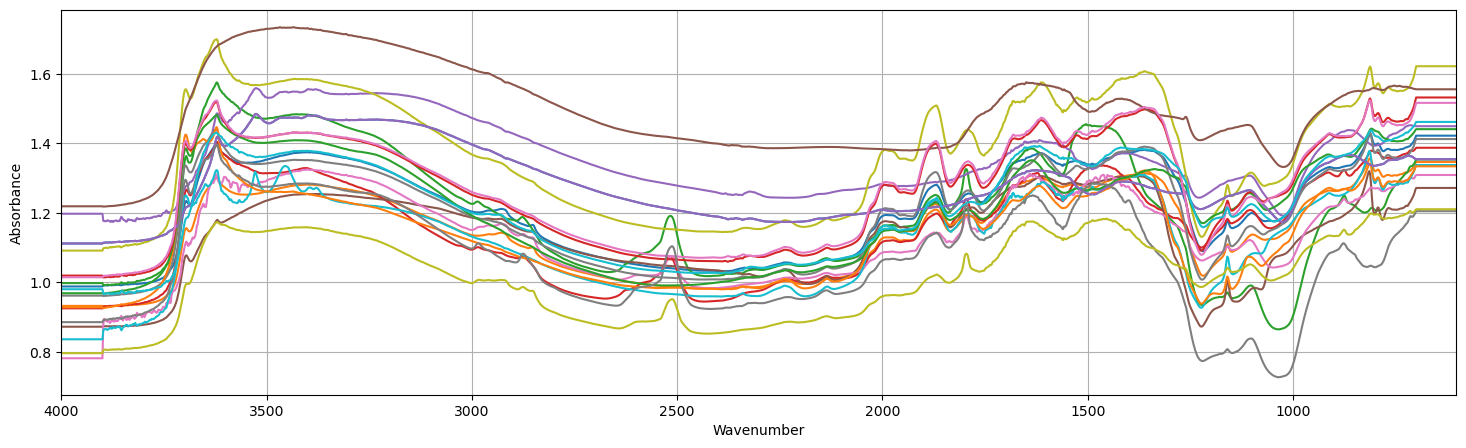

In [ ]:
# IAEA
plot_spectra(X_train, wns)

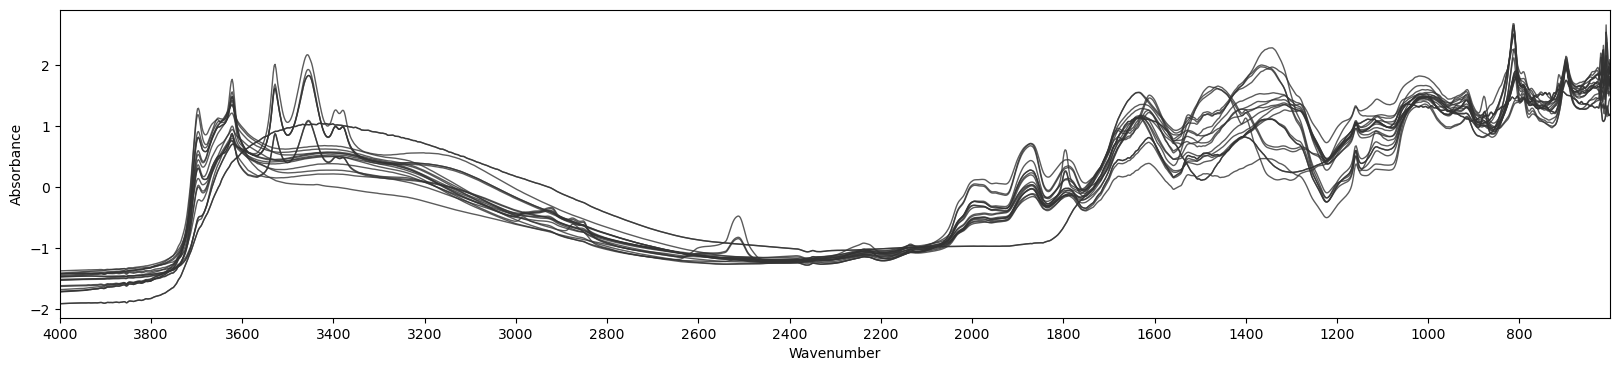

In [ ]:
# WCRC
plot_spectra(SNV().fit_transform(X_train), wns)

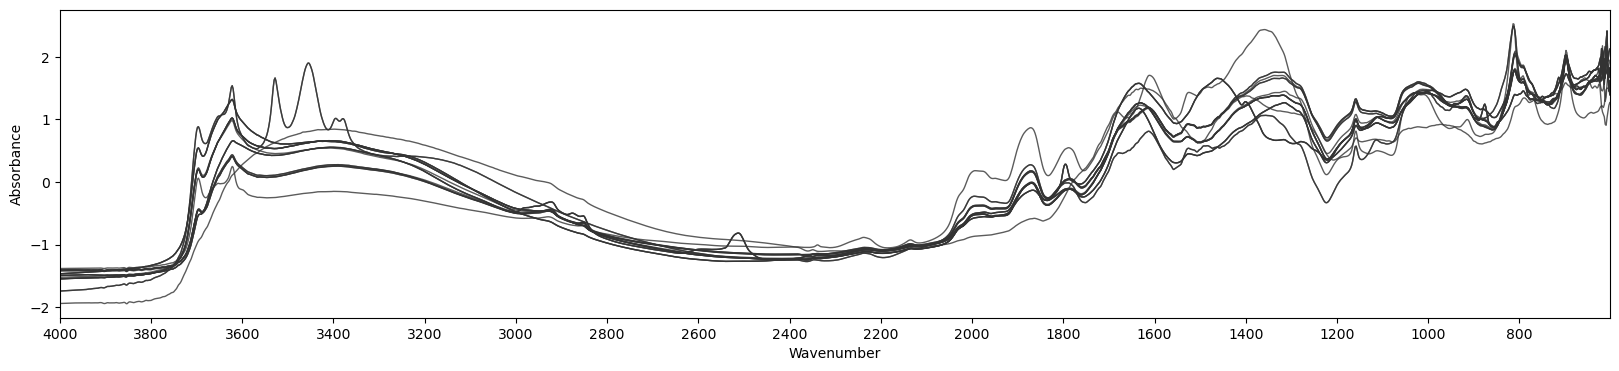

In [ ]:
plot_spectra(SNV().fit_transform(X_test), wns)

### Train locally

In [ ]:
param_grid = {'model__n_components': range(2,10)}

In [ ]:
pipe = Pipeline([
    ('snv', SNV()),
    ('derivative', TakeDerivative()),
    #('dropper', DropSpectralRegions(self.X_names, **self.pipeline_kwargs['dropper'])),
    ('model', PLSRegression())])

In [ ]:
search = GridSearchCV(pipe, param_grid, scoring='r2',
                      n_jobs=-1, refit=True, cv=5)

In [ ]:
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('snv', SNV()),
                                       ('derivative', TakeDerivative()),
                                       ('model', PLSRegression())]),
             n_jobs=-1, param_grid={'model__n_components': range(2, 10)},
             scoring='r2')

In [ ]:
search.best_score_

0.21151552246380745

In [ ]:
search.best_params_

{'model__n_components': 2}

In [ ]:
r2_score(y_test, search.best_estimator_.predict(X_test))

0.7889278578177632

<matplotlib.collections.PathCollection>

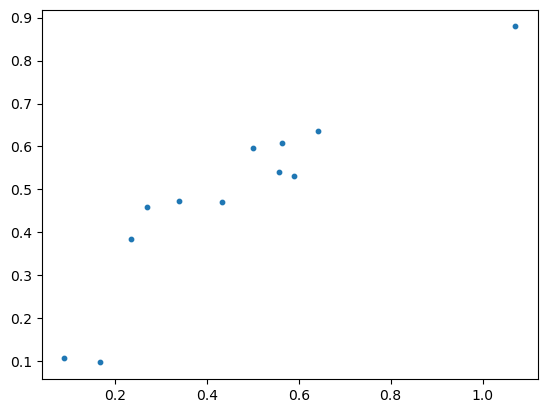

In [ ]:
plt.scatter(np.power(10, y_test), np.power(10, search.best_estimator_.predict(X_test)), s=10)

In [ ]:
np.c_[search.best_estimator_.predict(X_test), y_test]

array([[-0.48113693, -0.43513281],
       [-0.13333159, -0.20795869],
       [-0.19114174,  0.00732949],
       [-0.33790308, -0.36326143],
       [-0.3809995 , -0.62954243],
       [-0.16398953, -0.24947618],
       [-0.75066461, -0.72706822],
       [-0.89503624, -1.06600684],
       [-0.28207378, -0.25490959],
       [-0.34275221, -0.46885332],
       [-0.17516054, -0.01689717],
       [-0.33742686, -0.40990529],
       [-0.16788424, -0.31652068],
       [-0.37375972,  0.2191154 ],
       [-0.75879003, -0.78220032],
       [-0.33106434, -0.36478777],
       [-0.35511822, -0.41051956],
       [-0.97824273, -0.94877028],
       [-0.3776599 , -0.37529516],
       [-0.29374219, -0.31256915],
       [-0.13721125, -0.19295908],
       [-0.37531266, -0.57015086],
       [-0.35697361, -0.36209019],
       [-0.36331409, -0.44526862],
       [-0.0484345 , -0.01428619],
       [-0.96281745, -0.77502691],
       [-0.36347784, -0.39225554],
       [-0.16245175, -0.30168193],
       [-1.00025408,

### Trained with KSSL

In [ ]:
# TBD

# Pre-trained Resnet

In [ ]:
org = 'Woodwell_vertex'
#org = 'IAEA_jun2022'
#org = 'ETH_alpha_1'
analyte = 'potassium_cmolkg'

path = Path('../../_data/wcrc-ct-bundled') / org / analyte; path

Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg')

In [ ]:
(path / 'train').ls()

(#47) [Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_23'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_24'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_12'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_15'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_41'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_46'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_48'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_25'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_22'),Path('../../_data/wcrc-ct-bundled/Woodwell_vertex/potassium_cmolkg/train/RT_40')...]

## No fine tuning

In [ ]:
x_tfms = [get_spectra_files, to_spectra, snv]
y_tfms = [AnalytesTfm(analytes=[analyte]), torch.log10]

# Pre-trained model
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
#weights_paths = '../../_data/models/xresnet18-k-ex-snv-lr-5e-4-r2-0-828.pth'
weights_paths = '../../_data/models/xresnet18-v2-80-epochs-k-ex-snv-lr-1e-3-r2-0.84.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

In [ ]:
# Eval on train
dsets = Datasets((path / 'train').ls(), [x_tfms, y_tfms])
dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)
print(dls.train.one_batch()[0].shape)

y_train_hat = model(dls.train.one_batch()[0]).detach().numpy()
y_train_true = dls.train.one_batch()[1].numpy()

r2_score(y_train_true, y_train_hat)

torch.Size([47, 1, 1700])


0.3082997915601645

In [ ]:
# Eval on test
dsets = Datasets((path / 'test').ls(), [x_tfms, y_tfms])
dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)

print(dls.train.one_batch()[0].shape)
y_train_hat = model(dls.train.one_batch()[0]).detach().numpy()
y_train_true = dls.train.one_batch()[1].numpy()

r2_score(y_train_true, y_train_hat)

torch.Size([12, 1, 1700])


-1.226123471605049

## Fine tuning

In [ ]:
x_tfms = [get_spectra_files, to_spectra, snv]
y_tfms = [AnalytesTfm(analytes=[analyte]), torch.log10]

# Data loader
splits = RandomSplitter(seed=42, valid_pct=0.2)((path / 'train').ls())
dsets = Datasets((path / 'train').ls(), [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=16, num_workers=8, drop_last=False, shuffle=True)
print('ds size: ', dls.train.one_batch()[0].shape)

# Pre-trained model
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
#weights_paths = '../../_data/models/xresnet18-k-ex-snv-lr-5e-4-r2-0-828.pth'
weights_paths = '../../_data/models/xresnet18-v2-80-epochs-k-ex-snv-lr-1e-3-r2-0.84.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

ds size:  torch.Size([16, 1, 1700])


<All keys matched successfully>

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

In [ ]:
learn.freeze_to(-1)

SuggestedLRs(valley=0.0003981071640737355)

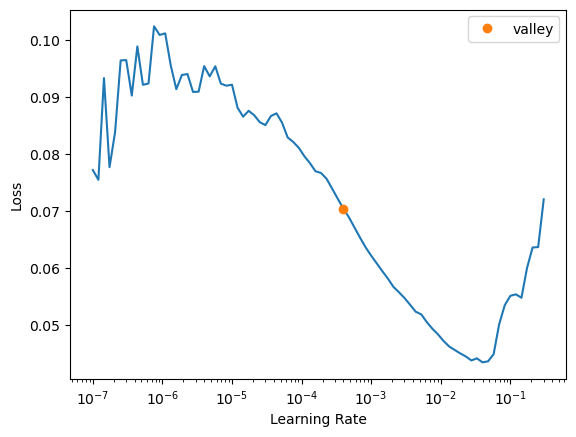

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 5e-4)

epoch,train_loss,valid_loss,r2_score,time
0,0.069773,0.052764,0.406949,00:03
1,0.059868,0.023693,0.733703,00:02
2,0.045824,0.018512,0.791933,00:02


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.0003981071640737355)

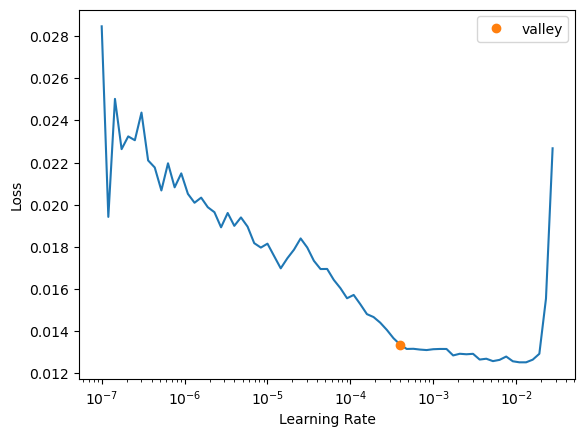

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,r2_score,time
0,0.014638,0.018765,0.789089,00:02
1,0.014762,0.018348,0.793776,00:02
2,0.013028,0.018455,0.792571,00:02
3,0.012420,0.016853,0.810578,00:02
4,0.011142,0.015615,0.824497,00:02
5,0.009782,0.015581,0.824878,00:02
6,0.009269,0.015031,0.831059,00:02


In [ ]:
# Eval on train
dsets = Datasets((path / 'train').ls(), [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)

y_train_hat = learn.model(dls.train.one_batch()[0]).detach().numpy()
y_train_true = dls.train.one_batch()[1].numpy()

r2_score(y_train_true, y_train_hat)

0.9627938822855997

<matplotlib.collections.PathCollection>

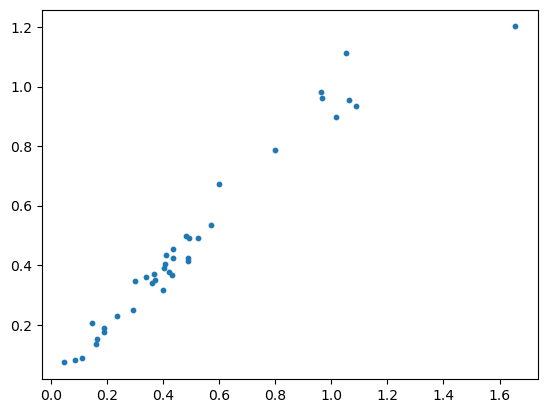

In [ ]:
plt.scatter(np.power(10, y_train_true), np.power(10, y_train_hat), s=10)

In [ ]:
# Eval on test
dsets = Datasets((path / 'test').ls(), [x_tfms, y_tfms])
dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)

print(dls.train.one_batch()[0].shape)
y_test_hat = learn.model(dls.train.one_batch()[0]).detach().numpy()
y_test_true = dls.train.one_batch()[1].numpy()

r2_score(y_test_true, y_test_hat)

torch.Size([12, 1, 1700])


0.7137801961127198

<matplotlib.collections.PathCollection>

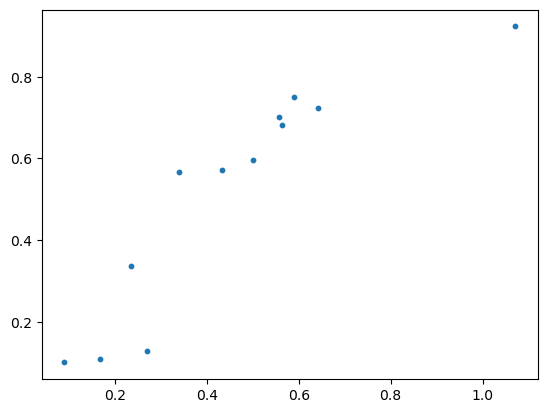

In [ ]:
plt.scatter(np.power(10, y_test_true), np.power(10, y_test_hat), s=10)

In [ ]:
np.c_[np.power(10, y_train_true), np.power(10, y_train_hat)]

array([[0.36717   , 0.42657986],
       [0.6195    , 0.5949031 ],
       [1.01702   , 0.8356816 ],
       [0.43325   , 0.42724413],
       [0.23467001, 0.21832235],
       [0.56302   , 0.6490161 ],
       [0.18747002, 0.18710388],
       [0.08590001, 0.07589787],
       [0.55602   , 0.636807  ],
       [0.33974   , 0.36799252],
       [0.96184   , 0.94069564],
       [0.38913   , 0.38011813],
       [0.48248   , 0.54315764],
       [1.65621   , 1.9689877 ],
       [0.16512002, 0.16077967],
       [0.43173   , 0.45532125],
       [0.38858   , 0.37242952],
       [0.11251999, 0.09870586],
       [0.42141   , 0.39785793],
       [0.48689002, 0.492641  ],
       [0.64127   , 0.58575726],
       [0.26905996, 0.327063  ],
       [0.43442   , 0.4231529 ],
       [0.3587    , 0.33552003],
       [0.96764   , 0.94396037],
       [0.16787   , 0.10140309],
       [0.40527   , 0.37695518],
       [0.49925   , 0.5531911 ],
       [0.08947   , 0.07497971],
       [0.58915   , 0.6748455 ],
       [0.